In [1]:
import os 
import numpy as np 
import pickle
from matplotlib import pyplot as plt
import matplotlib
import shutil
# import seaborn as sns
# from traj_run import rho_ohmic
from typing import Any
from numpy import dtype, ndarray
import scipy
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
import pywt
from data_analysis import read_line, read_exp, read_omega, get_rho_array, translate_param, chunk_data, interp_dat, do_fft, \
    fft_analysis, func_gentor, draw_t_S, draw_w_S

2024-10-23 17:15:11,961[INFO] Use NumPy as backend
2024-10-23 17:15:11,962[INFO] numpy random seed is 9012
2024-10-23 17:15:11,962[INFO] random seed is 1092
2024-10-23 17:15:11,964[INFO] Git Commit Hash: d897b277e9ff95f70c482307f2a5078cb59cac6a
2024-10-23 17:15:11,964[INFO] use 64 bits


In [2]:
# mother_folder0 = '/Users/ansatz/data/comp/sbm/vn_entropy_1site/24_07_04'
# mother_folder1 = '/Users/ansatz/data/comp/sbm/rho_check/'
todo_keys = ['s0.70-alpha0.05', 's0.7-alpha0.4', 's0.7-alpha0.8', 's0.30-alpha0.8', 's0.40-alpha0.8', 's0.50-alpha0.8']
mother_folder = '/home/ansatz/data/comp/sbm/24_09_09'

In [3]:
vn_entropy_1site_all_lines ={}
# for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
#     points = { i_step : f"_{i_step}_step_entropy_1sites.pickle" for i_step in range(100) }
#     nmodes = int(os.path.basename(line).split('_nmodes')[1].split('_')[0])

#     rho_type = 0 if 'rho_type' not in os.path.basename(line) else int(os.path.basename(line).split('rho_type_')[1])    
#     key = f"{line.split('_')[1]}-{line.split('_')[2]}-nmodes{nmodes}-rho{rho_type}"
#     print(key)
#     vn_entropy_1site_all_lines[key] = points
print('-----')
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(100) }
    nmodes = int(os.path.basename(line).split('_nmodes')[1].split('_')[0])

    rho_type = 0 if 'rho_type' not in os.path.basename(line) else int(os.path.basename(line).split('rho_type_')[1])
    key = f"{line.split('_')[1]}-{line.split('_')[2]}-nmodes{nmodes}-rho{rho_type}"
    # print(key)
    vn_entropy_1site_all_lines[key] = points

-----


In [4]:
vn_entropy_1site_all_lines.keys()

dict_keys(['s0.30-alpha0.48-nmodes1000-rho0', 's0.30-alpha0.48-nmodes1000-rho1', 's0.30-alpha0.48-nmodes800-rho0', 's0.30-alpha0.48-nmodes800-rho1', 's0.40-alpha0.05-nmodes1000-rho0', 's0.40-alpha0.05-nmodes1000-rho1', 's0.40-alpha0.05-nmodes800-rho0', 's0.40-alpha0.05-nmodes800-rho1', 's0.40-alpha0.20-nmodes1000-rho0', 's0.40-alpha0.20-nmodes1000-rho1', 's0.40-alpha0.20-nmodes800-rho0', 's0.40-alpha0.20-nmodes800-rho1', 's0.40-alpha0.40-nmodes1000-rho0', 's0.40-alpha0.40-nmodes1000-rho1', 's0.40-alpha0.40-nmodes800-rho0', 's0.40-alpha0.40-nmodes800-rho1', 's0.40-alpha0.48-nmodes1000-rho0', 's0.40-alpha0.48-nmodes1000-rho1', 's0.40-alpha0.48-nmodes800-rho0', 's0.40-alpha0.48-nmodes800-rho1', 's0.50-alpha0.48-nmodes1000-rho0', 's0.50-alpha0.48-nmodes1000-rho1', 's0.50-alpha0.48-nmodes800-rho0', 's0.50-alpha0.48-nmodes800-rho1', 's0.70-alpha0.05-nmodes1000-rho0', 's0.70-alpha0.05-nmodes1000-rho1', 's0.70-alpha0.05-nmodes800-rho0', 's0.70-alpha0.05-nmodes800-rho1', 's0.70-alpha0.40-nmodes

In [5]:
def show_result_t_S(s, alpha, nmodes, rho_type, step_length=1, query_modes=None):# -> tuple[list, list, list]:
    imodes = []
    ws = []
    freqs = []
    amps = []
    xfs = []
    fft_amps = []
    # s = 0.7
    # alpha = 0.05
    # nmodes = 1000
    # rho_type = 0
    pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

    # key = f's{s:.02f}-alpha{alpha:.02f}'
    key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
    if query_modes is not None:
        draw_lst = query_modes
    else:
        draw_lst = range(0, nmodes, step_length)
    for i in draw_lst:
        query_mode = i
        w, freq, amplitude, phase, xf, fft_amp = draw_t_S(pf, vn_entropy_1site_all_lines, key, query_mode)
        if w != 0 :
            imodes.append(query_mode)
            ws.append(w)
            freqs.append(freq)
            amps.append(amplitude)
            xfs.append(xf)
            fft_amps.append(fft_amp)
    return imodes, ws, freqs, amps, xfs, fft_amps, key

In [6]:
def show_fft_res(imodes, key, xfs, fft_amps, query_mode=None):
    plt.title(f'{key}')
    cuttoff_N = int(xfs[0].__len__() *0.001)
    print(f'cuttoff_N: {cuttoff_N}')
    if query_mode is None:
        for i in range(len(imodes)):
            imode = imodes[i]
            plt.plot(xfs[i][:cuttoff_N], np.real(fft_amps[i][:cuttoff_N]), '-', label=f'mode v{imode}')
    else:
        i = imodes.index(query_mode)
        print(f'query index{i}')
        plt.plot(xfs[i][:cuttoff_N], fft_amps[i][:cuttoff_N], '-', label=f'mode v{query_mode}')
        indexs , _ = scipy.signal.find_peaks(fft_amps[i][:cuttoff_N])
        peaks = [fft_amps[i][:cuttoff_N][index] for index in indexs]
        print(f'index: {indexs}')
        print(f'peaks: {peaks}')
        print(f'freq: {[xfs[i][:cuttoff_N][index] for index in indexs]}')
        highlight_x = []
        highlight_y = []
        for index in indexs:
            highlight_x.append(xfs[i][:cuttoff_N][index])
            highlight_y.append(np.real(fft_amps[i][:cuttoff_N][index]))
        plt.scatter(highlight_x, highlight_y, color='red')
    plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0))

def show_w_freqs(key, ws, freqs):
    plt.title(f'w-freq:{key}')
    plt.plot(ws, freqs,'-')
    plt.plot(ws, freqs,'o')
    plt.xlabel('freq of phonon')
    plt.ylabel('freq of S')
    plt.xlim(0,10)
    plt.ylim(0,max(freqs))

def show_w_freqs1(key, ws, freqs, imodes, xfs, fft_amps):
    plt.title(f'w-freq:{key}')
    cuttoff_N = int(xfs[0].__len__() *0.001)
    highlight_x = []
    highlight_y = []
    for imode in imodes:
        i = imodes.index(imode)
        w = ws[i]
        indexs , _ = scipy.signal.find_peaks(fft_amps[i][:cuttoff_N])
        peaks = [fft_amps[i][:cuttoff_N][index] for index in indexs]
        # print(f'index: {indexs}')
        # print(f'peaks: {peaks}')
        # print(f'freq: {[xfs[i][:cuttoff_N][index] for index in indexs]}')
        for index in indexs:
            # highlight_x.append(xfs[i][:cuttoff_N][index])
            # highlight_y.append(fft_amps[i][:cuttoff_N][index])
            highlight_x.append(w)
            highlight_y.append(xfs[i][:cuttoff_N][index])
    plt.scatter(highlight_x, highlight_y, color='red')
    # plt.plot(ws, freqs,'-')
    # plt.plot(ws, freqs,'o')
    plt.xlabel('freq of phonon')
    plt.ylabel('freq of S')
    plt.xlim(0,10)
    plt.ylim(0,max(highlight_y))

In [7]:

def get_data_of_vodf(s, alpha, nmodes, rho_type, idof , nsteps = 100):
    # s = 0.7
    # alpha = 0.05
    # nmodes = 1000
    # rho_type = 0
    
    pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

    key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}" 
    omgeas_eff, rho_array_eff, modes_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)
    # w = omgeas_eff[modes_eff.index(f'v_{idof}')]
    signal = [ dats[i][[modes_eff.index(f'v_{idof}')]] for i in range(nsteps) ]

    return signal


In [8]:
x = np.linspace(0, 10, 100)
x

array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
        6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96

In [9]:
signal = get_data_of_vodf(s=0.7, alpha=0.40, nmodes=1000, rho_type=0, idof=604, nsteps = 100)

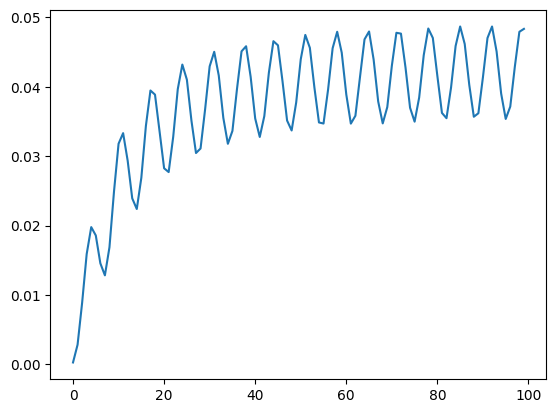

In [10]:
plt.plot(signal)

In [11]:
w = pywt.Wavelet('db2')

In [12]:
dir(w)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'biorthogonal',
 'dec_hi',
 'dec_len',
 'dec_lo',
 'family_name',
 'family_number',
 'filter_bank',
 'get_filters_coeffs',
 'get_reverse_filters_coeffs',
 'inverse_filter_bank',
 'name',
 'number',
 'orthogonal',
 'rec_hi',
 'rec_len',
 'rec_lo',
 'short_family_name',
 'symmetry',
 'vanishing_moments_phi',
 'vanishing_moments_psi',
 'wavefun']

In [13]:
w.filter_bank

([-0.12940952255126037,
  0.2241438680420134,
  0.8365163037378079,
  0.48296291314453416],
 [-0.48296291314453416,
  0.8365163037378079,
  -0.2241438680420134,
  -0.12940952255126037],
 [0.48296291314453416,
  0.8365163037378079,
  0.2241438680420134,
  -0.12940952255126037],
 [-0.12940952255126037,
  -0.2241438680420134,
  0.8365163037378079,
  -0.48296291314453416])

In [14]:
for family in pywt.families():

    print("%s family: " % family + ', '.join(pywt.wavelist(family)))

haar family: haar
db family: db1, db2, db3, db4, db5, db6, db7, db8, db9, db10, db11, db12, db13, db14, db15, db16, db17, db18, db19, db20, db21, db22, db23, db24, db25, db26, db27, db28, db29, db30, db31, db32, db33, db34, db35, db36, db37, db38
sym family: sym2, sym3, sym4, sym5, sym6, sym7, sym8, sym9, sym10, sym11, sym12, sym13, sym14, sym15, sym16, sym17, sym18, sym19, sym20
coif family: coif1, coif2, coif3, coif4, coif5, coif6, coif7, coif8, coif9, coif10, coif11, coif12, coif13, coif14, coif15, coif16, coif17
bior family: bior1.1, bior1.3, bior1.5, bior2.2, bior2.4, bior2.6, bior2.8, bior3.1, bior3.3, bior3.5, bior3.7, bior3.9, bior4.4, bior5.5, bior6.8
rbio family: rbio1.1, rbio1.3, rbio1.5, rbio2.2, rbio2.4, rbio2.6, rbio2.8, rbio3.1, rbio3.3, rbio3.5, rbio3.7, rbio3.9, rbio4.4, rbio5.5, rbio6.8
dmey family: dmey
gaus family: gaus1, gaus2, gaus3, gaus4, gaus5, gaus6, gaus7, gaus8
mexh family: mexh
morl family: morl
cgau family: cgau1, cgau2, cgau3, cgau4, cgau5, cgau6, cgau7, 

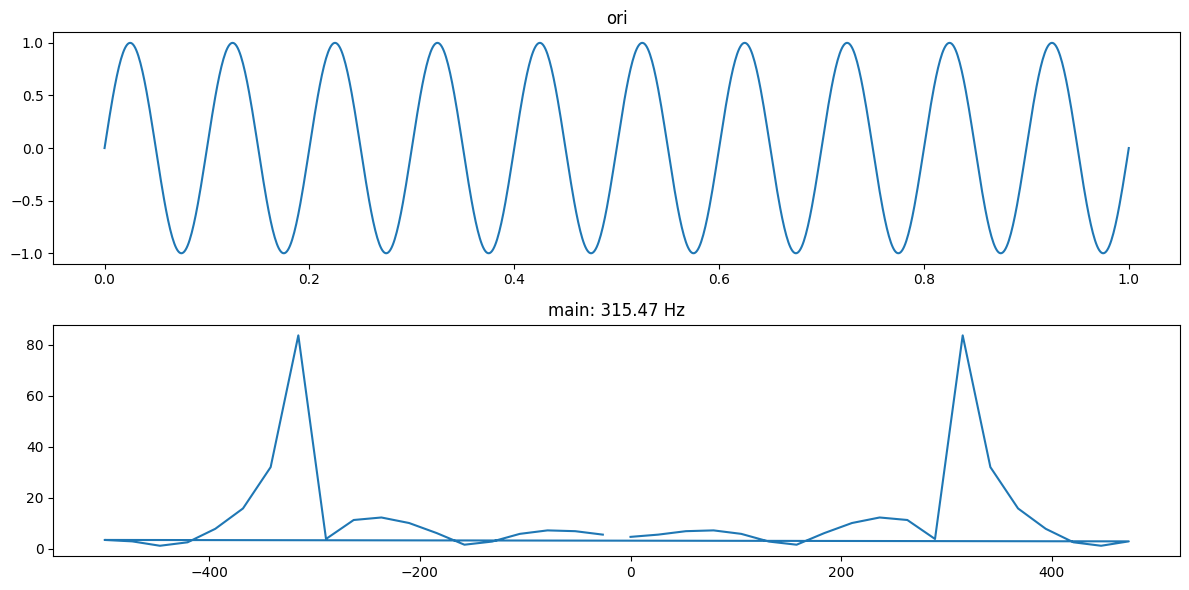

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# 生成一个简单的周期信号
t = np.linspace(0, 1, 1000)
signal = np.sin(2 * np.pi * 10 * t) 

# 进行小波变换
coeffs = pywt.wavedec(signal, 'db4', level=5)

# 近似系数通常包含低频信息，可以通过分析近似系数来估计主要频率
approx = coeffs[0]

# 计算近似系数的频谱
spectrum = np.abs(np.fft.fft(approx))
frequencies = fftfreq(len(approx), d=(t[1]-t[0]))

# 找到频谱中的峰值对应的频率
dominant_frequency_index = np.argmax(spectrum)
dominant_frequency = frequencies[dominant_frequency_index]

# 绘制原始信号和频谱
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(t, signal)
plt.title('ori')
plt.subplot(212)
plt.plot(frequencies, spectrum)
plt.title(f'main: {dominant_frequency:.2f} Hz')
plt.tight_layout()
plt.show()

In [21]:

# simply line
a=1
b=1
c=1
d=0.2
# complicated
e = 1
f = 2.0
g= 2
h= 2 

def t_S_func(type=0):
    def func1(x):
        func_value = a * np.sin(2* np.pi * b * x + c) + d + e * np.sqrt(x) 
        return func_value
    def func2(x):
        func_value = a * np.sin(2* np.pi * b * x + c) + d 
        return func_value
    if type == 0:
        return func1
    elif type == 1:
        return func2

def loss(x, true_dat=signal, loss_type=1, func_type=0):
    # a, b, c, d, e = params
    y_pred_func = t_S_func(type=func_type)
    y_pred = y_pred_func(x)
    if loss_type == 0:
        return np.linalg.norm(y_pred - true_dat)
    elif loss_type == 1:
        return np.mean((true_dat - y_pred)**2)

In [22]:
loss(x)

4.675129391852858

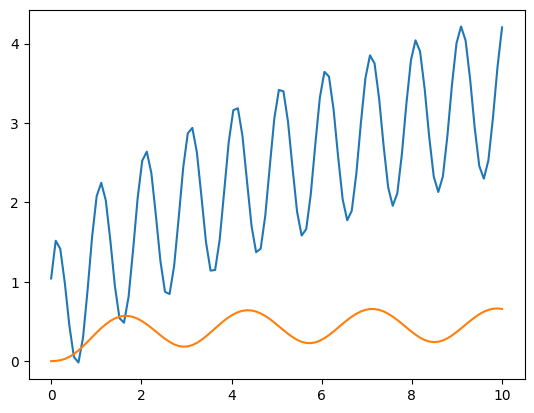

In [23]:
func = t_S_func(type=0)

y = func(x)
plt.plot(x, y, label='pred')
plt.plot(x, signal,label='ori')

In [24]:
par = scipy.optimize.minimize(loss, (a, b, c, d,e))

In [25]:
a, b, c, d, e= par.x

In [26]:
func = t_S_func()

y = func(x)

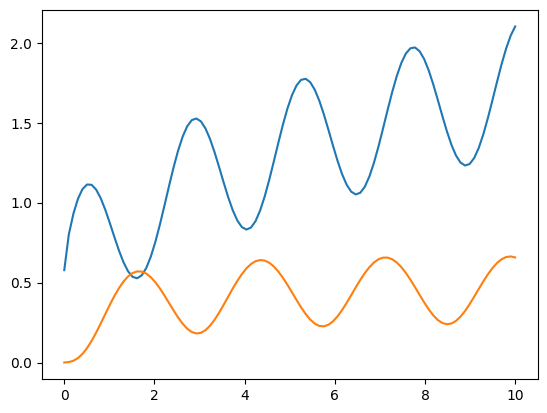

In [27]:
plt.plot(x, y)
plt.plot(x, signal)

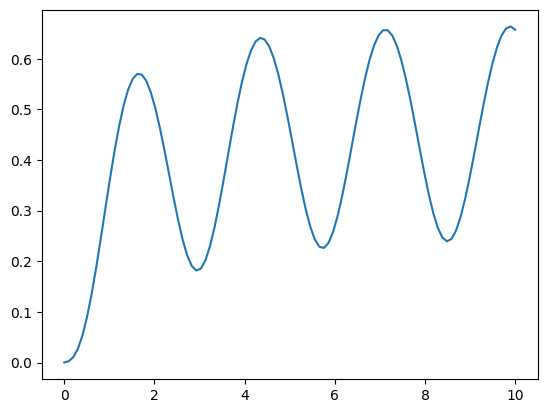

In [28]:
plt.plot(x, signal)

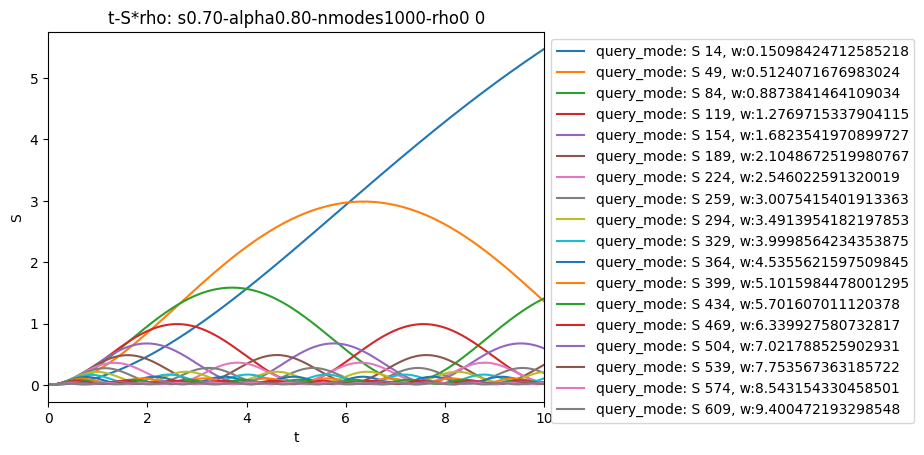

In [29]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.7, alpha=0.8, nmodes=1000, rho_type=0, step_length=7)

/tmp/ipykernel_42217/2923202531.py:33: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0,max(freqs))


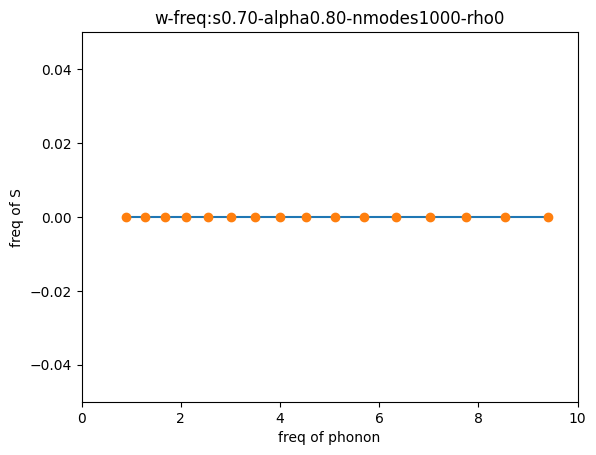

In [30]:
show_w_freqs(key, ws[2:], freqs[2:])

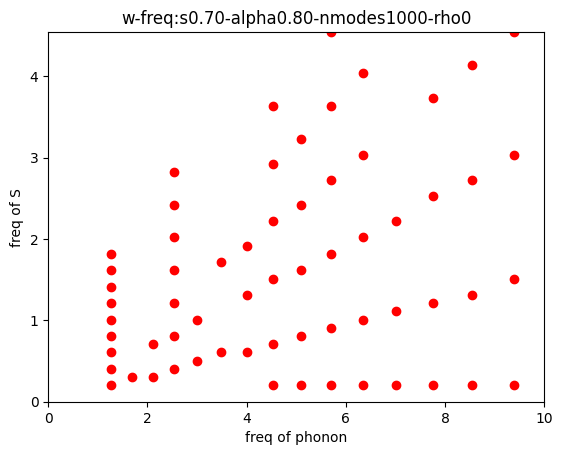

In [315]:
show_w_freqs1(key, ws, freqs, imodes, xfs, fft_amps)

cuttoff_N: 50
index: [ 2 15 30 45]
peaks: [np.float64(0.0005299301044883121), np.float64(0.008876063978958609), np.float64(0.0002870695015423781), np.float64(0.0001224763913623049)]
freq: [np.float64(0.20202020202020202), np.float64(1.5151515151515151), np.float64(3.0303030303030303), np.float64(4.545454545454545)]


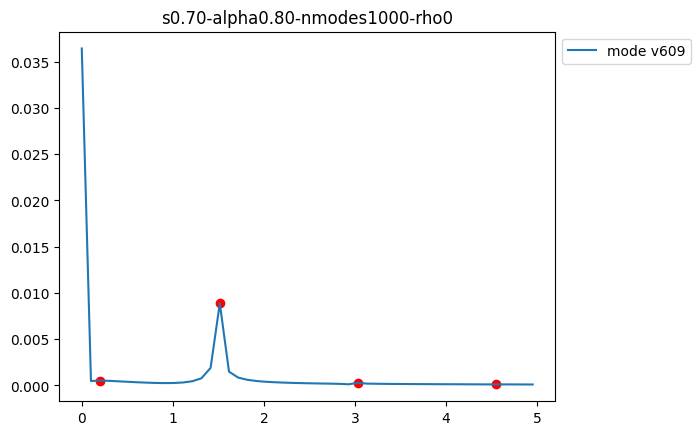

In [316]:
show_fft_res(imodes, key, xfs, fft_amps, query_mode=609)

In [ ]:
xfs[0].shape


In [ ]:
plt.plot(xfs[4])

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.7, alpha=0.4, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.7, alpha=0.4, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps, query_mode=224)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps, query_mode=294)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.7, alpha=0.4, nmodes=1000, rho_type=1, step_length=2)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.7, alpha=0.8, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps, query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.3, alpha=0.48, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.4, alpha=0.48, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.5, alpha=0.48, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.4, alpha=0.4, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.4, alpha=0.05, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.4, alpha=0.2, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.4, alpha=0.4, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.4, alpha=0.4, nmodes=1000, rho_type=1, step_length=2)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.3, alpha=0.48, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.3, alpha=0.48, nmodes=1000, rho_type=1, step_length=2)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.4, alpha=0.48, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.4, alpha=0.48, nmodes=1000, rho_type=1, step_length=2)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.5, alpha=0.48, nmodes=1000, rho_type=0, step_length=7)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
imodes, ws, freqs, amps, xfs, fft_amps, key = show_result_t_S(s=0.5, alpha=0.48, nmodes=1000, rho_type=1, step_length=2)

In [ ]:
show_w_freqs(key, ws, freqs)

In [ ]:
show_fft_res(imodes, key, xfs, fft_amps,query_mode=None)

In [ ]:
assert 0

# W-S

In [ ]:
s = 0.7
alpha = 0.05
nmodes= 1000
rho_type = 0
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
draw_w_S(pf, vn_entropy_1site_all_lines, key)

In [ ]:
s = 0.7
alpha = 0.40
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
draw_w_S(pf, vn_entropy_1site_all_lines, f's{s:.02f}-alpha{alpha:.02f}')

In [ ]:
s = 0.7
alpha = 0.80
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
draw_w_S(pf, vn_entropy_1site_all_lines, f's{s:.02f}-alpha{alpha:.02f}')

In [ ]:
s = 0.7
alpha = 0.05
nmodes = 1000
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"{line.split('_')[1]}-{line.split('_')[2]}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.7
alpha = 0.4
nmodes = 1000
rho_type = 1 

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.7
alpha = 0.8
nmodes = 1000
rho_type = 1 

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.7
alpha = 0.05
nmodes = 800
rho_type = 0

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.7
alpha = 0.4
nmodes = 800
rho_type = 0

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.7
alpha = 0.8
nmodes = 800
rho_type = 0

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.7
alpha = 0.05
nmodes = 800
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.7
alpha = 0.4
nmodes = 800
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.7
alpha = 0.8
nmodes = 800
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.3
alpha = 0.8
nmodes = 1000
rho_type = 0
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
draw_w_S(pf, vn_entropy_1site_all_lines,  f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.4
alpha = 0.8
nmodes = 1000
rho_type = 0
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
s = 0.5
alpha = 0.8
nmodes = 1000
rho_type = 0
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
draw_w_S(pf, vn_entropy_1site_all_lines, f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}")

In [ ]:
freq_dict = {}
query_istep = 95

In [ ]:



s = 0.7
alpha = 0.05

pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
key = f's{s:.02f}-alpha{alpha:.02f}'
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)


for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
func = func_gentor(freq, amplitude, phase)


i_step = query_istep
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)


new_singnal = func(omgeas_eff_uniform, popt[0], popt[1], popt[2], popt[3])
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(omgeas_eff_uniform, singnal_niform, 'o', label='Interpolated Signal')
plt.plot(omgeas_eff_uniform, new_singnal, '-', label='New Func Signal')
plt.title('Interpolated and New Func Signal')
plt.xlabel('freq')
plt.ylabel('S*rho')
plt.legend()

In [ ]:



s = 0.7
alpha = 0.4

pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
key = f's{s:.02f}-alpha{alpha:.02f}'
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)

i_step = 90

for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)

omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq

func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff_uniform, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff_uniform, singnal_niform, 'o', label='Interpolated Signal')
# plt.plot(omgeas_eff_uniform, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:



s = 0.7
alpha = 0.8

pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
key = f's{s:.02f}-alpha{alpha:.02f}'
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)



for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)

omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq

func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff_uniform, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff_uniform, singnal_niform, 'o', label='Interpolated Signal')
# plt.plot(omgeas_eff_uniform, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:

s = 0.7
alpha = 0.05
nmodes = 1000
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)
plt.clf()
new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(omgeas_eff, dats[i_step], '-', label='Ori Signal')
plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')

plt.title('Ori and New Func Signal')
plt.xlabel('freq')
plt.ylabel('S*rho')
plt.legend()

In [ ]:

s = 0.7
alpha = 0.4
nmodes = 1000
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(omgeas_eff, dats[i_step], '-', label='Ori Signal')
plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')
plt.title('Interpolated and New Func Signal')
plt.xlabel('freq')
plt.ylabel('S*rho')
plt.legend()

In [ ]:

s = 0.7
alpha = 0.8
nmodes = 1000
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(omgeas_eff, dats[i_step], '-', label='Ori Signal')
plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')
plt.title('Interpolated and New Func Signal')
plt.xlabel('freq')
plt.ylabel('S*rho')
plt.legend()

In [ ]:

s = 0.7
alpha = 0.05
nmodes = 800
rho_type = 0

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff, dats[i_step], 'o', label='Ori Signal')
# plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:

s = 0.7
alpha = 0.4
nmodes = 800
rho_type = 0

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff, dats[i_step], 'o', label='Ori Signal')
# plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:

s = 0.7
alpha = 0.8
nmodes = 800
rho_type = 0

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff, dats[i_step], 'o', label='Ori Signal')
# plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:

s = 0.7
alpha = 0.05
nmodes = 800
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff, dats[i_step], 'o', label='Ori Signal')
# plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:

s = 0.7
alpha = 0.4
nmodes = 800
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(omgeas_eff, dats[i_step], '-', label='Ori Signal')
plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')
plt.title('Interpolated and New Func Signal')
plt.xlabel('freq')
plt.ylabel('S*rho')
plt.legend()

In [ ]:

s = 0.7
alpha = 0.8
nmodes = 800
rho_type = 1

pf = os.path.join(mother_folder1, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')
key = f"s{s:.02f}-alpha{alpha:.02f}-nmodes{nmodes}-rho{rho_type}"
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)




for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)
    
omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq
func = func_gentor(freq, amplitude, phase)


popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

new_singnal = func(omgeas_eff, popt[0], popt[1], popt[2], popt[3])
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(omgeas_eff, dats[i_step], '-', label='Ori Signal')
plt.plot(omgeas_eff, new_singnal, '-', label='New Func Signal')
plt.title('Interpolated and New Func Signal')
plt.xlabel('freq')
plt.ylabel('S*rho')
plt.legend()

In [ ]:



s = 0.3
alpha = 0.8
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
key = f's{s:.02f}-alpha{alpha:.02f}'
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)

i_step = 90

for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)

omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq

func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff_uniform, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff_uniform, singnal_niform, 'o', label='Interpolated Signal')
# plt.plot(omgeas_eff_uniform, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:



s = 0.4
alpha = 0.8
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
key = f's{s:.02f}-alpha{alpha:.02f}'
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)

i_step = 90

for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)

omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq

func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff_uniform, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff_uniform, singnal_niform, 'o', label='Interpolated Signal')
# plt.plot(omgeas_eff_uniform, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:



s = 0.5
alpha = 0.8
pf = os.path.join(mother_folder0, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0')
key = f's{s:.02f}-alpha{alpha:.02f}'
omgeas_eff, rho_array_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key)

i_step = 90

for i_step in range(100):
    omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[i_step])
    xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
    freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
    print(freq, amplitude, phase)

omgeas_eff_uniform, singnal_niform = interp_dat(omgeas_eff, dats[query_istep])
xf, yf = do_fft(omgeas_eff_uniform, singnal_niform)
freq, amplitude, phase = fft_analysis(xf, yf, omgeas_eff_uniform.shape[0])
freq_dict[key] = freq

func = func_gentor(freq, amplitude, phase)


# popt, pcov = curve_fit(func, omgeas_eff_uniform, singnal_niform)

# new_singnal = func(omgeas_eff_uniform, popt[0], popt[1], popt[2], popt[3])
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(omgeas_eff_uniform, singnal_niform, 'o', label='Interpolated Signal')
# plt.plot(omgeas_eff_uniform, new_singnal, '-', label='New Func Signal')
# plt.title('Interpolated and New Func Signal')
# plt.xlabel('freq')
# plt.ylabel('S*rho')
# plt.legend()

In [ ]:
freq_dict

In [ ]:
for key in freq_dict:
    print(key, 1/freq_dict[key])

In [ ]:

T = (x_uniform.max() - x_uniform.min()) / N  # sample Time
yf = fft(signal_uniform)
xf = fftfreq(N, T)[:N//2]


plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x, signal, 'o', label='Original Signal')
plt.plot(x_uniform, signal_uniform, '-', label='Interpolated Signal')
plt.title('Original and Interpolated Signal')
plt.xlabel('freq')
plt.ylabel('S*rho')
plt.legend()


In [ ]:
# map
fft_amp = 2.0/N *np.abs(yf[:N//2])
plt.subplot(2, 1, 2)
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title('FFT of the Interpolated Signal')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [ ]:
indexs , _= scipy.signal.find_peaks(fft_amp)
index = indexs[0]
index

In [ ]:
freq = main_freq = xf[index]
freq

In [ ]:
amplitude = 2.0/N * np.abs(yf[index])
phase = np.angle(yf[index])

In [ ]:
def func_gentor(freq, phase):

    def signal_func(x, a, b, c,  d, amp):
        return a * np.exp(-b* (x**c) + amp * np.sin(2.0 * np.pi * freq * x + phase))  + d

    return signal_func

In [ ]:
func = func_gentor(freq, phase)


In [ ]:
# x = x.tolist()
# signal = signal.tolist()

popt, pcov = scipy.optimize.curve_fit(func, x.ravel(), signal.ravel())

In [ ]:
pcov

In [ ]:
2.0 * np.pi * freq

In [ ]:
newy = func(x, popt[0], popt[1], popt[2], popt[3])
# T = (x_uniform.max() - x_uniform.min()) / N  # 采样间隔
# yf = fft(signal_uniform)
# xf = fftfreq(N, T)[:N//2]


plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x, signal, 'o', label='Original Signal')
plt.plot(x, newy, '-', label='Func Signal')
plt.title('Original and Func Signal')
plt.xlabel('freq')
plt.ylabel('S*rho')
plt.legend()


In [ ]:
amp

In [ ]:
! pip install PyWavelets

In [ ]:
import pywt

In [ ]:

coeffs = pywt.wavedec(signal_uniform, 'db1', level=6)

In [ ]:
fig, ax = plt.subplots(len(coeffs), 1, figsize=(10, 12))
for i, coeff in enumerate(coeffs):
    ax[i].plot(coeff)
    ax[i].set_title(f'Level {i} Coefficients')
plt.tight_layout()
plt.show()

In [ ]:
xf.shape[0]

In [ ]:
vn_entropy_1site_all_lines.keys()

In [ ]:
key

In [ ]:
mother_folder0

In [17]:
from data_analysis import rho_ohmic, translate_param
s= 0.7
alpha =0.8
omega_c = 10
Omega = 1
rho_type= 1
nmodes = 1000

In [ ]:
s_reno, alpha_reno, omega_c_reno = translate_param(s, alpha, omega_c, Omega)
sdf = rho_ohmic(alpha_reno, omega_c_reno, s_reno, rho_type)
w, c2 = sdf.Wang1(nmodes)
w[w<10].shape

In [21]:
w_eff = w[w < 10]

In [ ]:
w_eff.shape

In [ ]:
w_eff.shape[0]/w.shape[0]

In [ ]:
w_eff

In [47]:
import pywt

In [ ]:
pywt.families()

In [ ]:
for family in pywt.families():
    print("%s family: " % family + ', '.join(pywt.wavelist(family)))

In [51]:
w = pywt.Wavelet('db3')

In [ ]:
dir(w)

In [ ]:
def print_array(arr):

    print("[%s]" % ", ".join(["%.14f" % x for x in arr]))

In [ ]:
w.filter_bank

In [55]:
w = pywt.Wavelet('sym3')
w.orthogonal
(phi, psi, x) = w.wavefun(level=5)

In [56]:
import pywt
x = [3, 7, 1, 1, -2, 5, 4, 6]
cA, cD = pywt.dwt(x, 'db2')

In [ ]:
plt.plot(x)

In [ ]:
plt.plot(cD)